<div style="text-align: center; font-size: 20px; font-weight: bold;">
<h1>ACC5 - Forecasting Day 1 Homework: Exploring and Understanding a Time Series</h1>
</div>

## Introduction

This homework focuses on exploring and analyzing time series data. The dataset contains records at **30-minute intervals**, and the goal is to resample and investigate its properties. Follow the tasks below to guide your analysis.

**Tasks**

1. **Verify Index Completeness**  
   - Check if the time series index is complete and without gaps.  
   - Compare the index against an expected range of timestamps (e.g., using `pd.date_range`) to identify missing entries.

2. **Resample and Aggregate**  
   - Resample data to **1-hour intervals** using `pandas.resample`.  
   - Explore the effects of the `label` and `closed` arguments to understand how intervals are aligned and closed.  
   - Use `mean` as the aggregation method for resampling.

3. **Inspect Null Values**  
   - Check for missing values after resampling.  
   - Propose and implement a **strategy to handle** null values (e.g., forward-fill, interpolation, or dropping) even if none exist.

4. **Analyze Key Characteristics**  
   - Identify and visualize **trends** in the data.  
   - Check for **level-dispersion association** by analyzing whether variability changes with the series level (e.g., higher values showing more variability).  
   - Explore **seasonality**: identify potential frequencies (e.g., daily, weekly) and determine which are most relevant.

5. **Detect Outliers**  
   - Identify outliers.  
   - Propose a strategy to handle them, and explain the rationale behind your approach.

6. **Decompose the Series**  
   - Use `statsmodels` to decompose the series into trend, seasonality, and residuals.  

7. **Study Autocorrelation**  
   - Examine autocorrelations using tools like `acf` and `pacf` from `statsmodels`.  
   - Autocorrelation measures how a time series is related to itself at different time lags. Does the value at one point in time influence the values at later points?
   - Partial autocorrelation measures the direct relationship between a value and its lag, after removing the influence of intermediate lags. It helps isolate the effect of a specific lag.

**Deliverables**

- A notebook with code and visualizations addressing each task.  
- Brief observations and conclusions for each analysis.

## Libraries

Make sure you are using skforecast `0.14.0`.

In [93]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.datasets import fetch_dataset
from statsmodels.tsa.seasonal import seasonal_decompose

## Data

A time series of electricity demand (MW) is available for the state of Victoria (Australia) from 2011-12-31 to 2014-12-31 is available. The data used in this document has been obtained from the **R** [tsibbledata]("https://tsibbledata.tidyverts.org") package. The dataset contains 5 columns and 52,608 complete records. The information in each column is:

+ Time: date and time of the record.
+ Date: date of the record.
+ Demand: electricity demand (MW).
+ Temperature: temperature in Melbourne, the capital of Victoria.
+ Holiday: indicates if the day is a public holiday.

In [62]:
# Data download
# ==============================================================================
data = fetch_dataset(name='vic_electricity', raw=True)
data = data.drop(columns="Date")
data.head(5)

vic_electricity
---------------
Half-hourly electricity demand for Victoria, Australia
O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse
Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,
https://github.com/tidyverts/tsibbledata/.
https://tsibbledata.tidyverts.org/reference/vic_elec.html
Shape of the dataset: (52608, 5)


,Time,Demand,Temperature,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,True


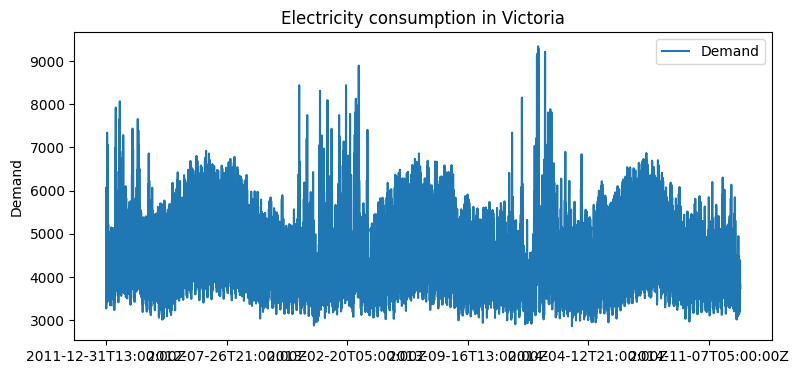

In [63]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data.plot(x='Time', y='Demand', ax=ax)
ax.set_title('Electricity consumption in Victoria')
ax.set_xlabel('')
ax.set_ylabel('Demand')
plt.show()

## Exercises

### 1. Verify Index Completeness
- Check if the time series index is complete and without gaps.
- Compare the index against an expected range of timestamps (e.g., using `pd.date_range`) to identify missing entries.

In [64]:
date_range = pd.date_range(start=data['Time'].min(), end=data['Time'].max(), freq='0.5h')

In [65]:
print("Num of missing dates: ", len(date_range) - len(data['Time'].unique()))

Num of missing dates:  0


### 2. Resample and Aggregate
- Resample data to **1-hour intervals** using `pandas.resample`.
- Explore the effects of the `label` and `closed` arguments to understand how intervals are aligned and closed.
- Use `mean` as the aggregation method for resampling.

In [66]:
# Convert 'Time' column to datetime
data['Time'] = pd.to_datetime(data['Time'])

# Resample data to 1-hour intervals and use mean as the aggregation method
data_resampled = data.resample('1H', on="Time", closed="left", label="left").mean()

# Reset index to make 'Time' a column again
data_resampled.reset_index(inplace=True)

data_resampled.head()

/var/folders/nw/ssdc3p8s1pqbp4lsgsj33ys00000gp/T/ipykernel_52056/3207222997.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample('1H', on="Time", closed="left", label="left").mean()


,Time,Demand,Temperature,Holiday
0,2011-12-31 13:00:00+00:00,4323.095350,21.225,1.0
1,2011-12-31 14:00:00+00:00,3963.264688,20.625,1.0
2,2011-12-31 15:00:00+00:00,3950.913495,20.325,1.0
3,2011-12-31 16:00:00+00:00,3627.860675,19.850,1.0
4,2011-12-31 17:00:00+00:00,3396.251676,19.025,1.0


### 3. Inspect Null Values
- Check for missing values after resampling.
- Propose and implement a **strategy to handle** null values (e.g., forward-fill, interpolation, or dropping) even if none exist.


In [67]:
data_resampled.isnull().sum()

Time           0
Demand         0
Temperature    0
Holiday        0
dtype: int64

I would implement a forward-fill strategy to handle null values. As this avoids introducing lookahead bia.

In [68]:
data_resampled.fillna(method='ffill', inplace=True)

/var/folders/nw/ssdc3p8s1pqbp4lsgsj33ys00000gp/T/ipykernel_52056/1208548778.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_resampled.fillna(method='ffill', inplace=True)


### 4. Analyze Key Characteristics
- Identify and visualize **trends** in the data.
- Check for **level-dispersion association** by analyzing whether variability changes with the series level (e.g., higher values showing more variability).
- Explore **seasonality**: identify potential frequencies (e.g., daily, weekly) and determine which are most relevant.


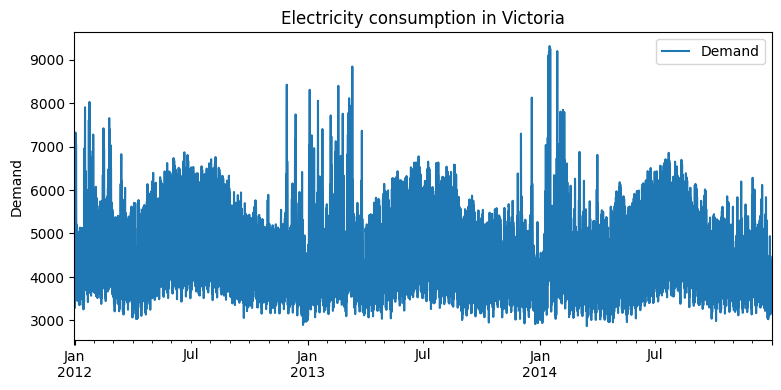

In [69]:
fig, ax = plt.subplots(figsize=(9, 4))
data_resampled.plot(x='Time', y='Demand', ax=ax)
ax.set_title('Electricity consumption in Victoria')
ax.set_xlabel('')
ax.set_ylabel('Demand')
plt.show()


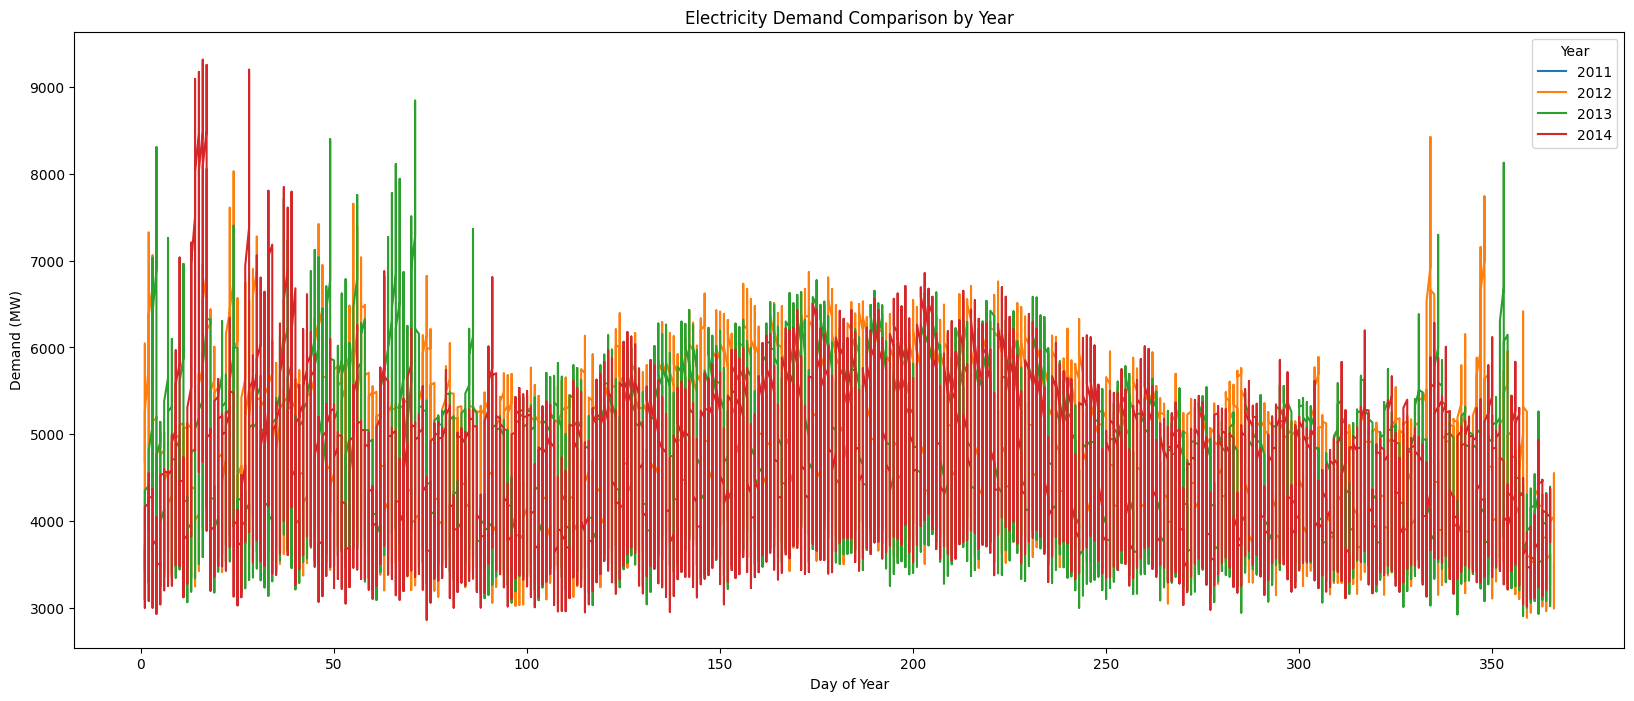

In [72]:
# Create a new column for the day of the year
data_resampled['day_of_year'] = data_resampled['Time'].dt.dayofyear

# Plot the demand for each year independently
fig, ax = plt.subplots(figsize=(20, 8))

for year in data_resampled['Time'].dt.year.unique():
    data_year = data_resampled[data_resampled['Time'].dt.year == year]
    ax.plot(data_year['day_of_year'], data_year['Demand'], label=year)

ax.set_title('Electricity Demand Comparison by Year')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Demand (MW)')
ax.legend(title='Year')
plt.show()

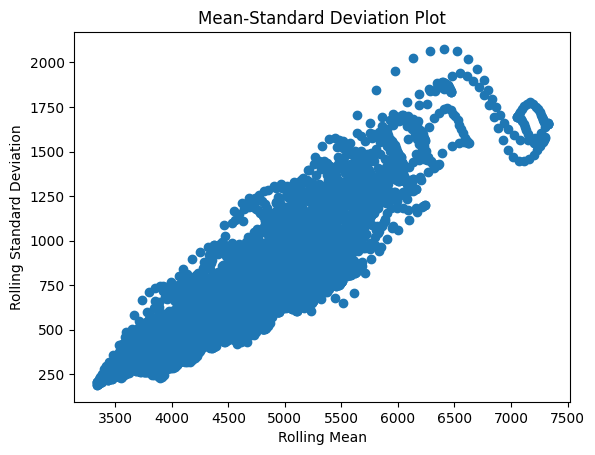

In [133]:
window = 24

rolling_mean = data_resampled["Demand"].rolling(window=window).mean()
rolling_std = data_resampled["Demand"].rolling(window=window).std()

plt.scatter(rolling_mean, rolling_std)
plt.xlabel("Rolling Mean")
plt.ylabel("Rolling Standard Deviation")
plt.title("Mean-Standard Deviation Plot")
plt.show()

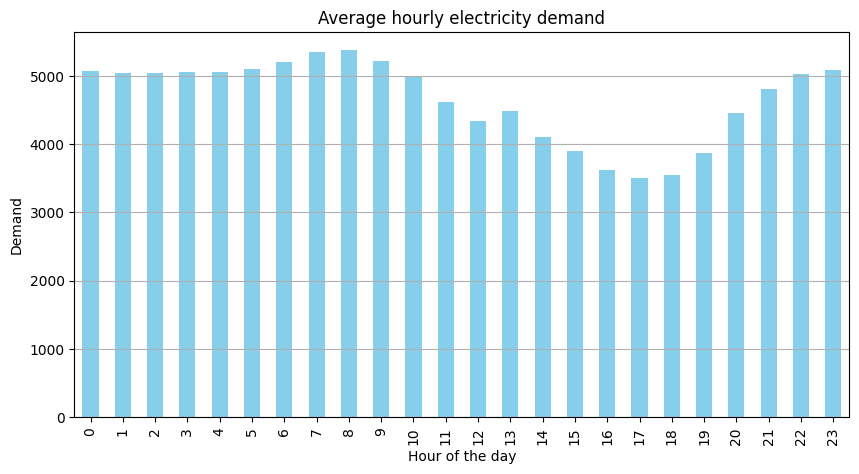

In [139]:
data_resampled['hour'] = data_resampled['Time'].dt.hour
hourly_pattern = data_resampled.groupby('hour')['Demand'].mean()

plt.figure(figsize=(10, 5))
hourly_pattern.plot(kind='bar', color='skyblue')
plt.title('Average hourly electricity demand')
plt.xlabel('Hour of the day')
plt.ylabel('Demand')
plt.grid(axis='y')
plt.show()

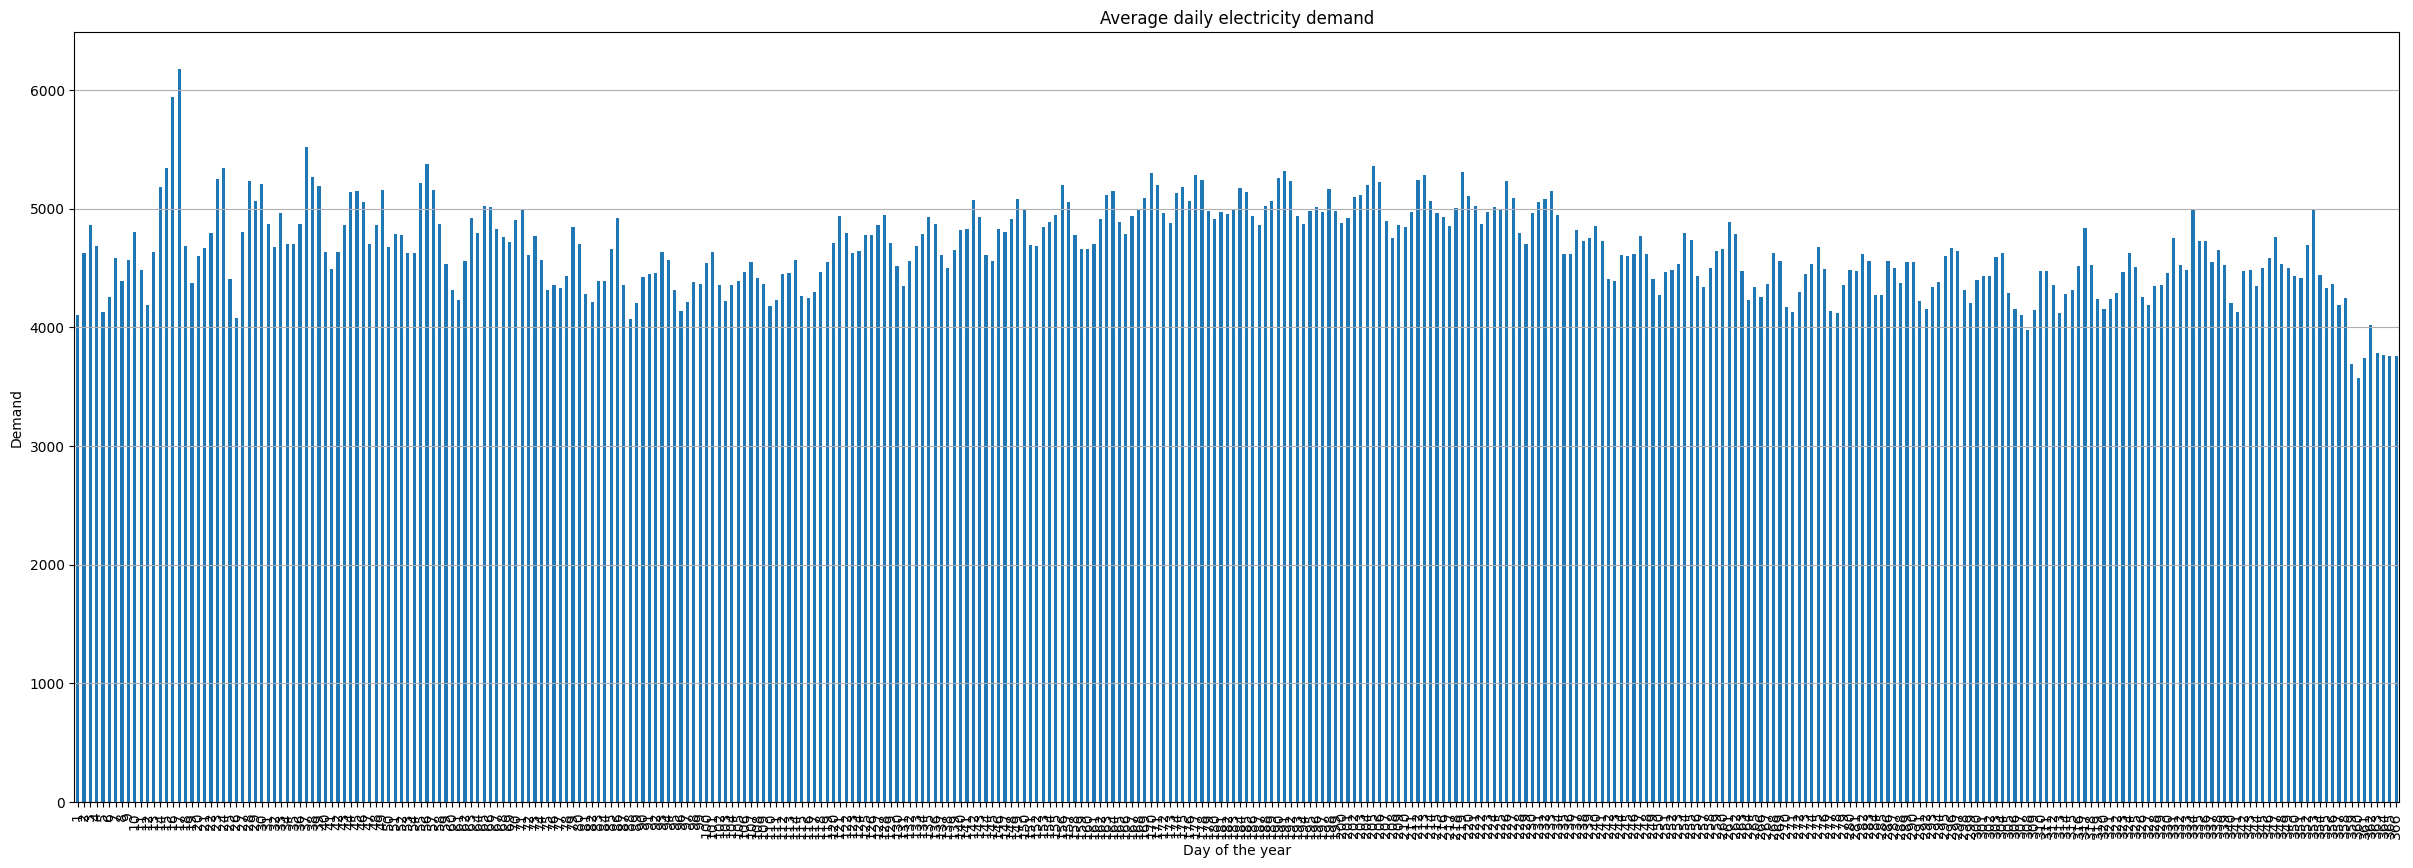

In [142]:
data_resampled['day_of_year'] = data_resampled['Time'].dt.dayofyear
daily_pattern = data_resampled.groupby('day_of_year')['Demand'].mean()

plt.figure(figsize=(30, 10))
daily_pattern.plot(kind='bar')
plt.title('Average daily electricity demand')
plt.xlabel('Day of the year')
plt.ylabel('Demand')
plt.grid(axis='y')
plt.show()

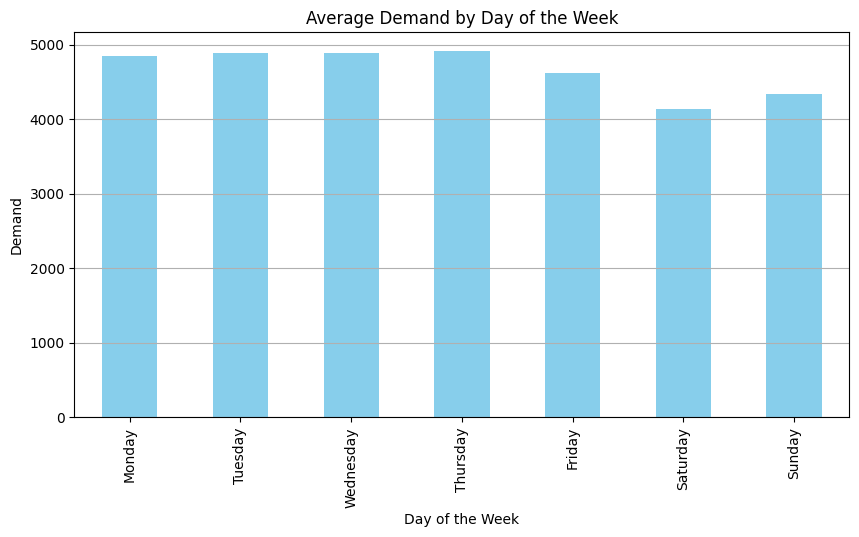

In [138]:
#Study weekly pattern
data_resampled['day_of_week'] = data_resampled['Time'].dt.dayofweek
weekly_pattern = data_resampled.groupby('day_of_week')['Demand'].mean()

# Map day_of_week numbers to actual weekday names
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_pattern.index = days

# Plot the average visits per day of the week
plt.figure(figsize=(10, 5))
weekly_pattern.plot(kind='bar', color='skyblue')
plt.title('Average Demand by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Demand')
plt.grid(axis='y')
plt.show()


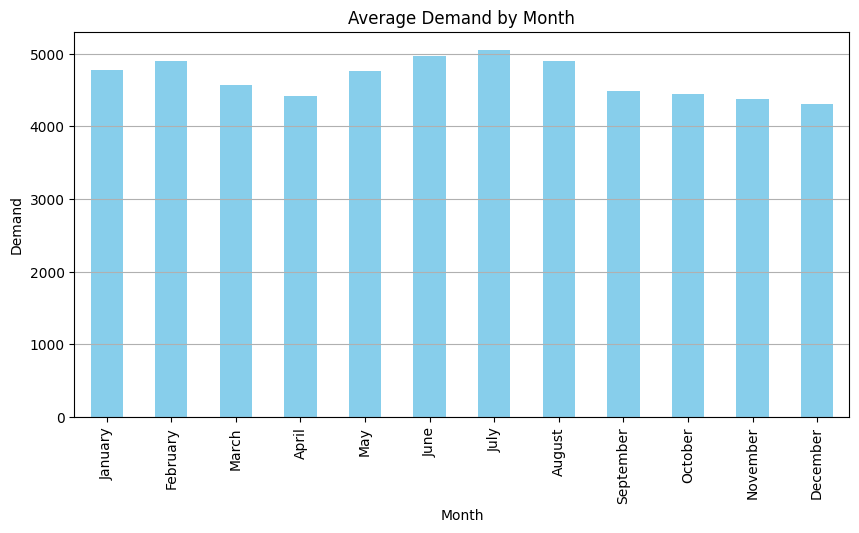

In [143]:
data_resampled['month'] = data_resampled['Time'].dt.month
monthly_pattern = data_resampled.groupby('month')['Demand'].mean()

# Map month numbers to actual month names
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_pattern.index = months

# Plot the average visits per month
plt.figure(figsize=(10, 5))
monthly_pattern.plot(kind='bar', color='skyblue')
plt.title('Average Demand by Month')
plt.xlabel('Month')
plt.ylabel('Demand')
plt.grid(axis='y')
plt.show()

### 5. Detect Outliers
- Identify outliers.
- Propose a strategy to handle them, and explain the rationale behind your approach.


<Axes: >

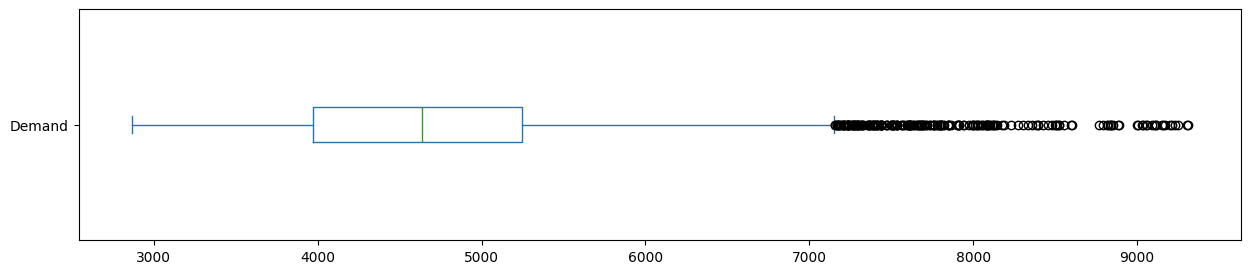

In [79]:
data_resampled['Demand'].plot(kind='box', vert=False, figsize=(15, 3))

<Axes: ylabel='Frequency'>

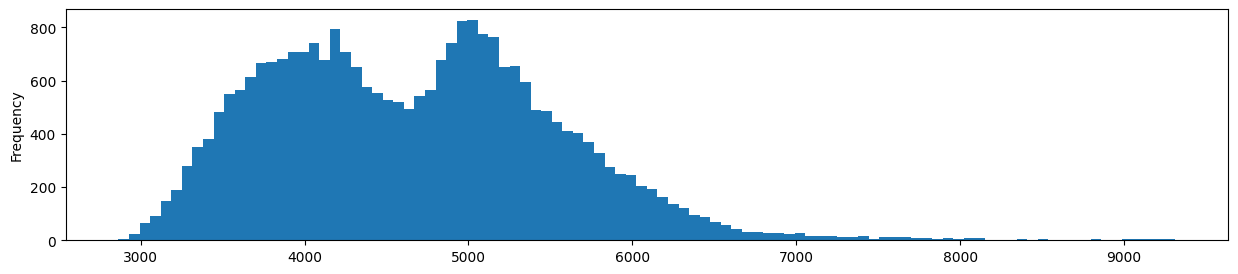

In [89]:
data_resampled['Demand'].plot(kind='hist', bins=100, figsize=(15, 3))

<Axes: >

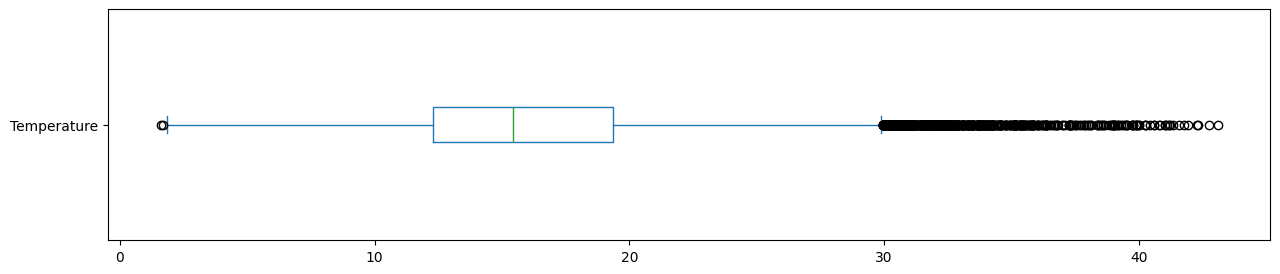

In [85]:
data_resampled['Temperature'].plot(kind='box', vert=False, figsize=(15, 3))

<Axes: ylabel='Frequency'>

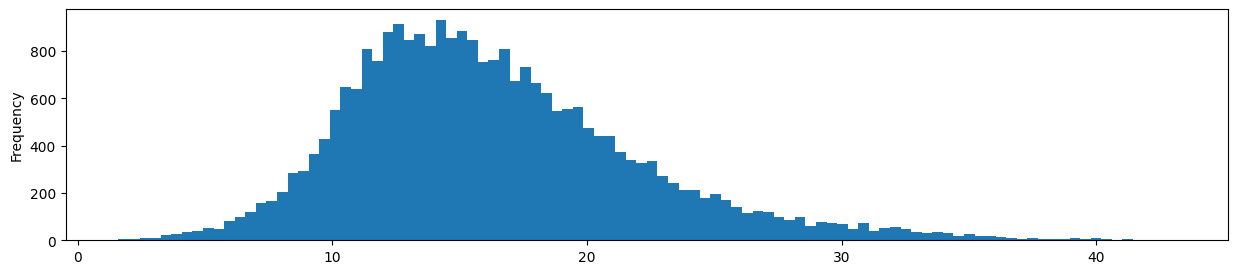

In [88]:
data_resampled['Temperature'].plot(kind='hist', bins=100, figsize=(15, 3))

Replace outliers with the median value of the demand. The median is less sensitive to extreme values compared to the mean, making it a robust choice for replacing outliers.


### 6. Decompose the Series
- Use `statsmodels` to decompose the series into trend, seasonality, and residuals.


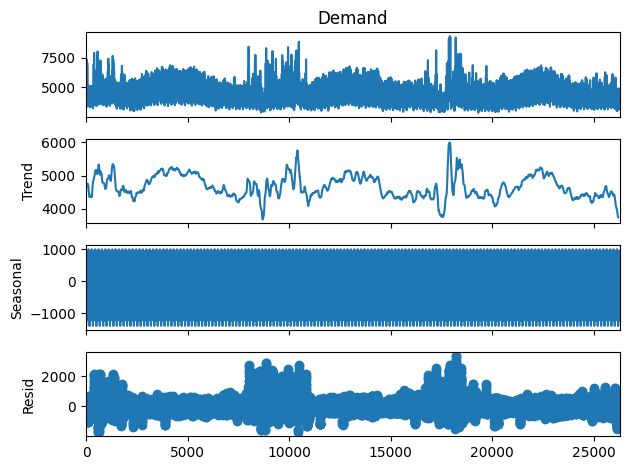

In [144]:
seasonal_decompose(data_resampled['Demand'], model='additive', period=24*7).plot()
plt.show()

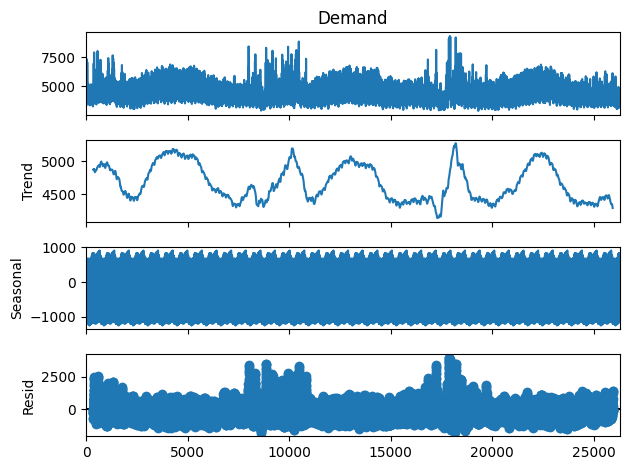

In [145]:
seasonal_decompose(data_resampled['Demand'], model='additive', period=24*30).plot()
plt.show()

### 7. Study Autocorrelation
- Examine autocorrelations using tools like `acf` and `pacf` from `statsmodels`.
- Autocorrelation measures how a time series is related to itself at different time lags. Does the value at one point in time influence the values at later points?
- Partial autocorrelation measures the direct relationship between a value and its lag, after removing the influence of intermediate lags. It helps isolate the effect of a specific lag.


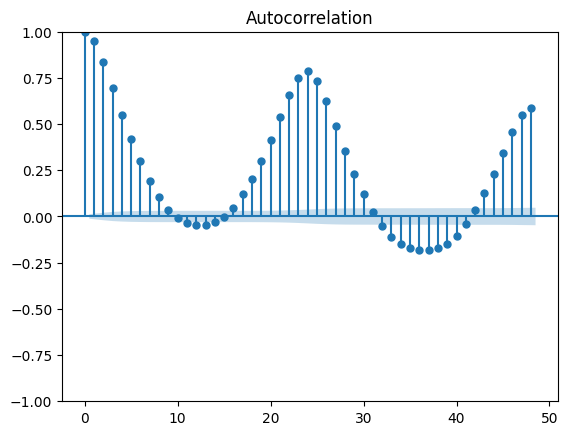

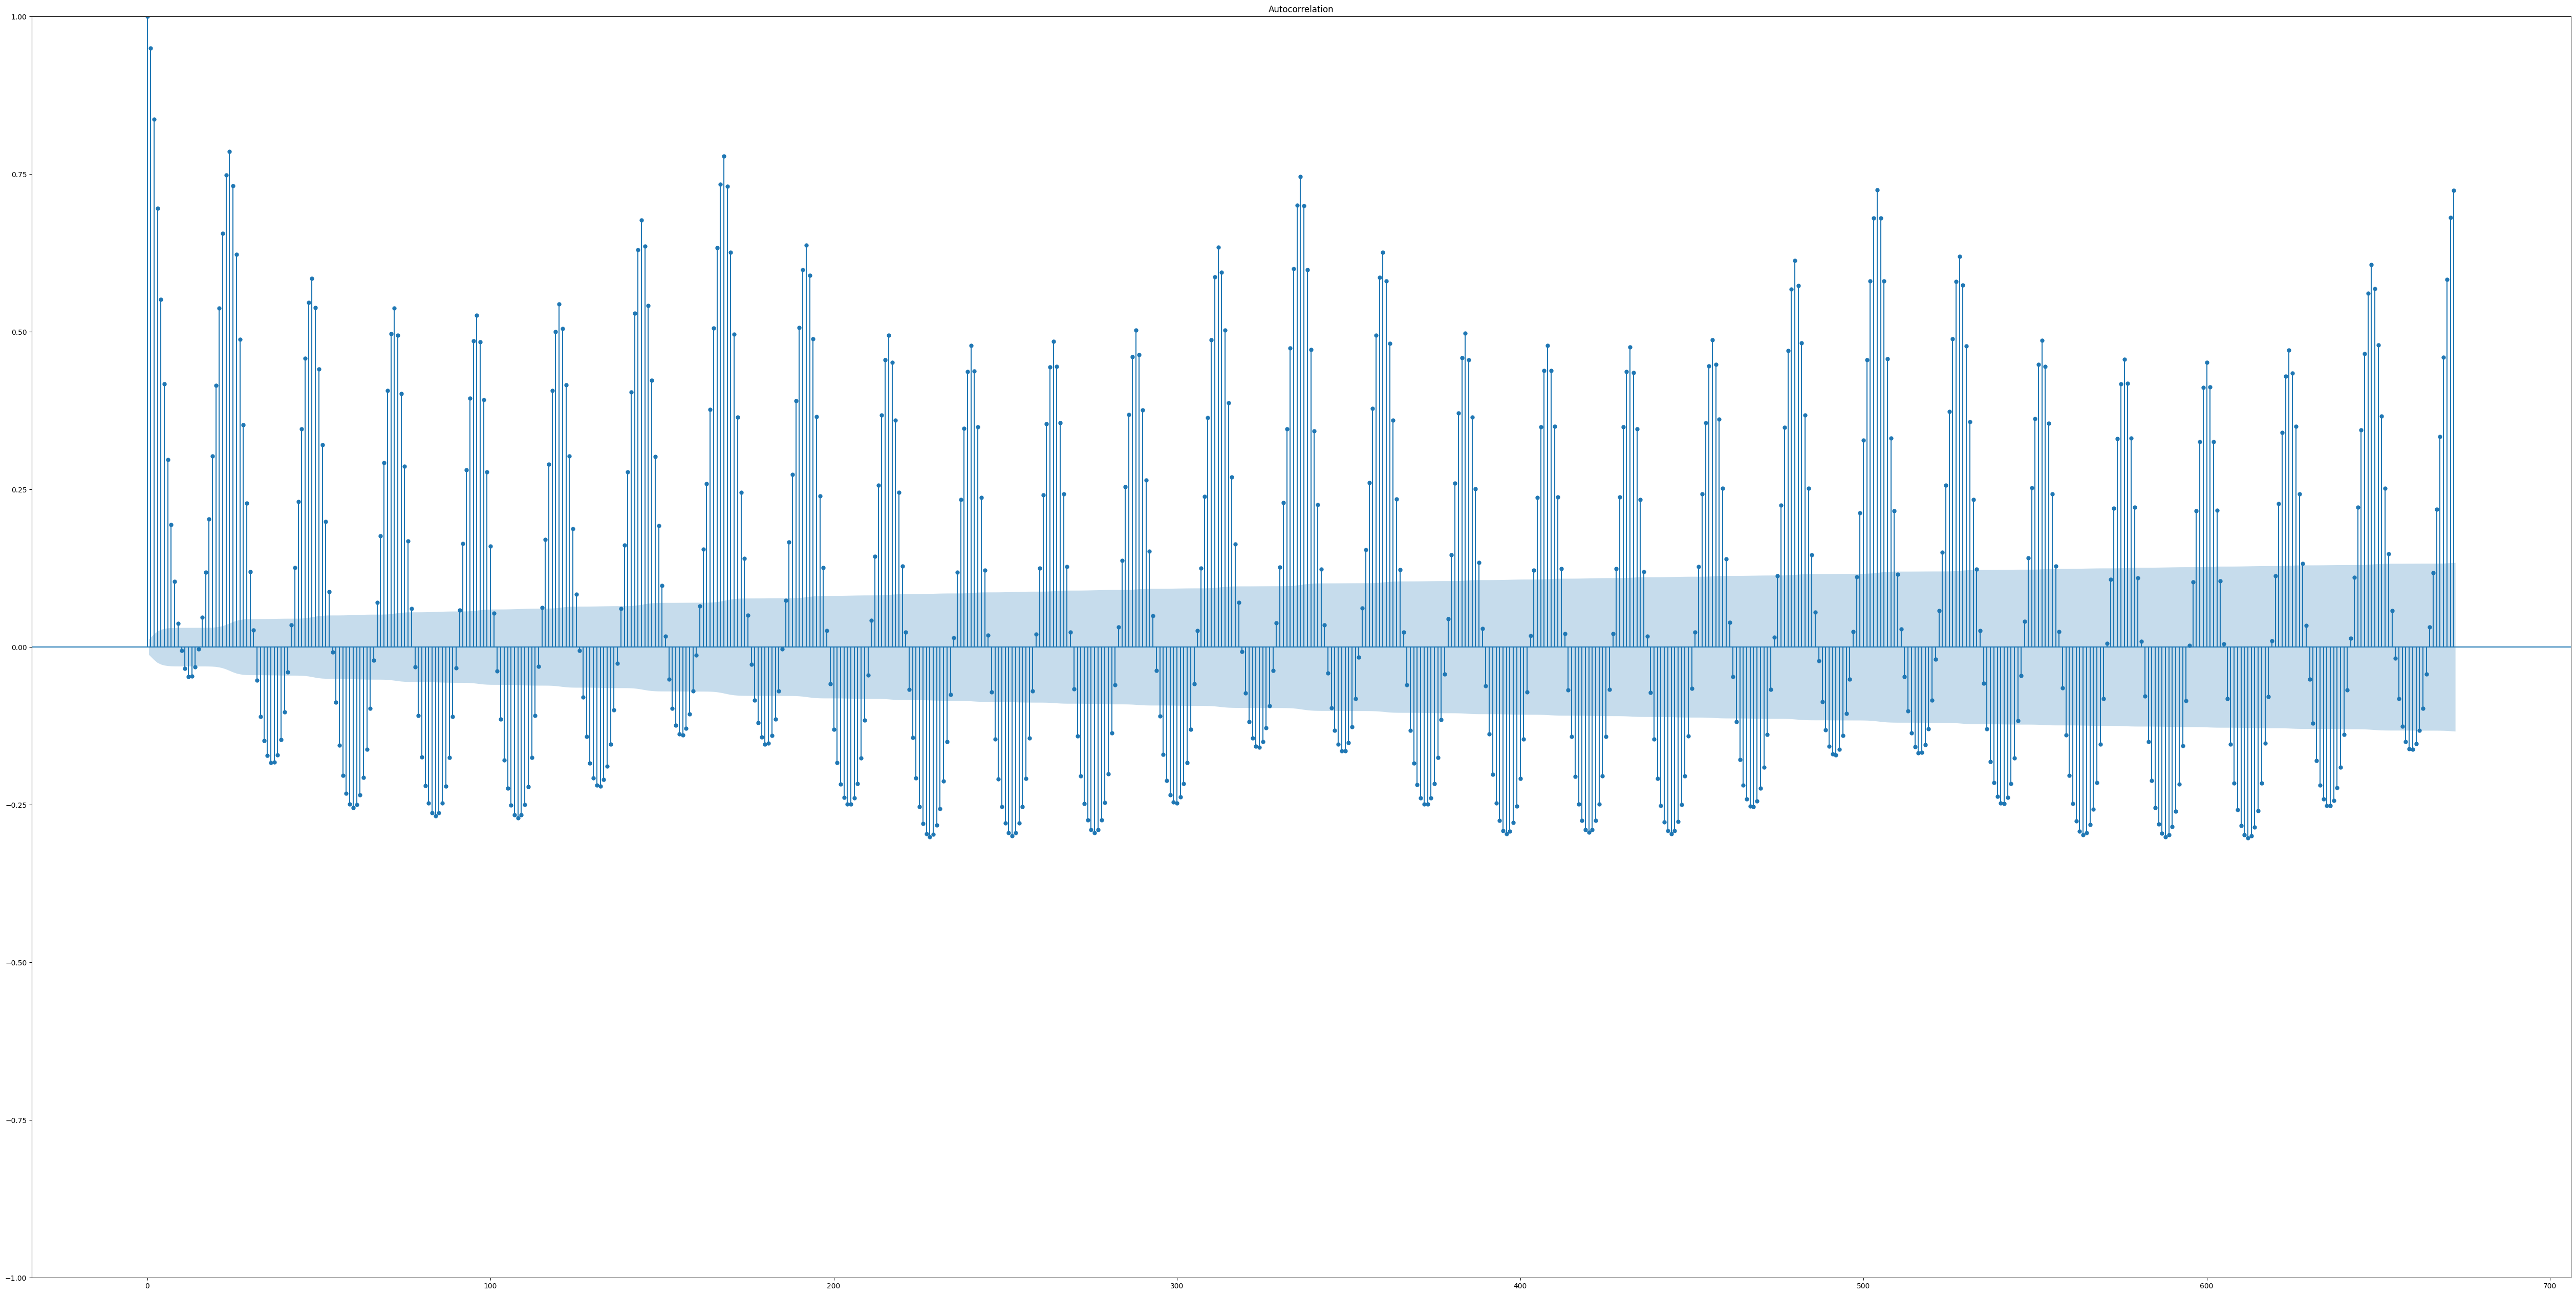

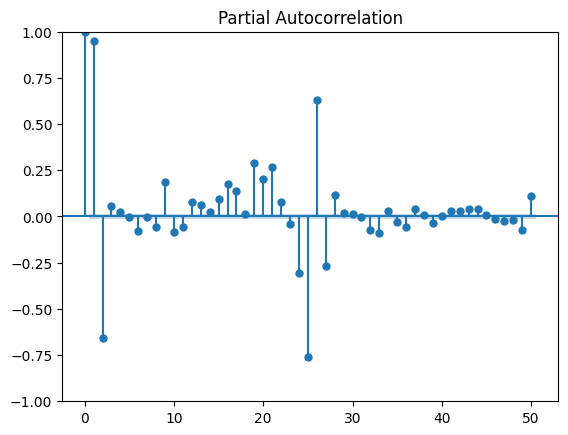

In [147]:
# examine autocorrelation and partial autocorrelation using statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_resampled['Demand'], lags=48)
plt.show()

# Create a figure with a larger size
fig, ax = plt.subplots(figsize=(64, 32))  # Adjust figsize as needed (width, height)
plot_acf(data_resampled['Demand'], lags=24*7*4, ax=ax)
plt.show()


#Plot pacf
plot_pacf(data_resampled['Demand'], lags=50)
plt.show()
